In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

Importing plotly failed. Interactive plots will not work.


In [2]:
#Importing data
Shenyang = pd.read_csv("D:/Math546 Time series/final projects/PM2.5 Data of Five Chinese Cities Data Set/ShenyangPM20100101_20151231.csv")

In [3]:
Shenyang.dropna(axis=0, how="any",inplace=True)

In [4]:
# from datetime import datetime
Shenyang['Time'] = pd.to_datetime(Shenyang['year'].map(str) +"/"+ Shenyang['month'].map(str) +"/"+ Shenyang['day'].map(str)+" "+Shenyang['hour'].map(str)+":00:00")
#Shenyang

In [5]:
by_hour = Shenyang.groupby(['Time']).mean()
print(by_hour.head())

                        No  year  month  day  hour  season  PM_Taiyuanjie  \
Time                                                                        
2013-04-22 13:00:00  28982  2013      4   22    13       1          141.0   
2013-04-23 10:00:00  29003  2013      4   23    10       1           59.0   
2013-04-23 16:00:00  29009  2013      4   23    16       1          200.0   
2013-04-24 08:00:00  29025  2013      4   24     8       1          120.0   
2013-04-24 16:00:00  29033  2013      4   24    16       1           11.0   

                     PM_US Post  PM_Xiaoheyan  DEWP   HUMI    PRES  TEMP  \
Time                                                                       
2013-04-22 13:00:00       113.0         140.0  -1.0  25.89  1013.0  19.0   
2013-04-23 10:00:00        59.0          49.0  -5.0  26.40  1012.0  14.0   
2013-04-23 16:00:00       106.0         152.0   2.0  50.36  1010.0  12.0   
2013-04-24 08:00:00       136.0         137.0   6.0  87.19  1010.0   8.0   
2013

In [6]:
by_hour.index = pd.to_datetime(by_hour.index, 
                             format='%d-%m-%Y %H:%M:%S')
by_hour = by_hour.set_index(by_hour.index).asfreq('H')
by_hour = by_hour.fillna(method='ffill')

print(by_hour.index)

DatetimeIndex(['2013-04-22 13:00:00', '2013-04-22 14:00:00',
               '2013-04-22 15:00:00', '2013-04-22 16:00:00',
               '2013-04-22 17:00:00', '2013-04-22 18:00:00',
               '2013-04-22 19:00:00', '2013-04-22 20:00:00',
               '2013-04-22 21:00:00', '2013-04-22 22:00:00',
               ...
               '2015-12-31 12:00:00', '2015-12-31 13:00:00',
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00'],
              dtype='datetime64[ns]', name='Time', length=23601, freq='H')


In [7]:
by_hour['Time'] = by_hour.index

In [8]:
data_13 = by_hour[(by_hour['Time'] >=pd.to_datetime('20140101030000')) & (by_hour['Time'] <= pd.to_datetime('20151231030000'))]

In [9]:
data_13 = data_13.set_index(data_13.index).asfreq('H')

In [10]:
#########################################################################################################

In [11]:
#Creat some time series features to see how the trends are impacted by day of week, hour, time of year, etc.

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(data_13, label='PM_US Post')

features_and_target = pd.concat([X, y], axis=1)

In [12]:
# See our features and target
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PM_US Post
Time,,,,,,,,,
2014-01-01 03:00:00,3,2,1,1,2014,1,1,1,31.0
2014-01-01 04:00:00,4,2,1,1,2014,1,1,1,21.0
2014-01-01 05:00:00,5,2,1,1,2014,1,1,1,31.0
2014-01-01 06:00:00,6,2,1,1,2014,1,1,1,31.0
2014-01-01 07:00:00,7,2,1,1,2014,1,1,1,36.0


In [13]:
###############################################################################################################

In [14]:
#Plotting the Features to see trends

##Power demand has strong daily and seasonal properties.
##Day of week also seems to show differences in peaks.

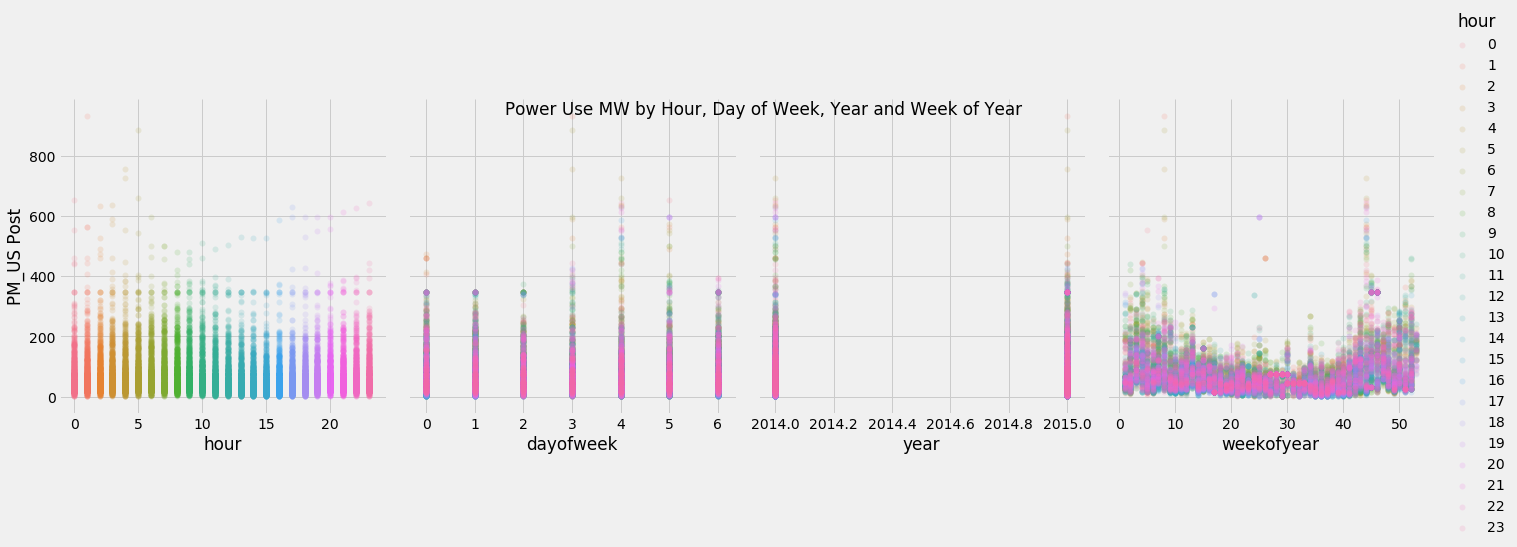

In [15]:
 sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='PM_US Post',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

In [16]:
###############################################################################################################

In [17]:
#Train/Test Split
##Cut off the data after 2015 to use as our validation set. We will train on earlier data.

In [18]:
split_date = '2015-10-01 03:00:00'
data_13_train = data_13.loc[data_13.index <= split_date].copy()
data_13_test = data_13.loc[data_13.index > split_date].copy()

In [19]:
###############################################################################################################

In [20]:
# Format data for prophet model using ds and y
## Use parameter drop=True which not create new column with index but remove it

data_13_train.reset_index(drop=True) \
    .rename(columns={'Time':'ds',
                     'PM_US Post':'y'}).head()

,No,year,month,day,hour,season,PM_Taiyuanjie,y,PM_Xiaoheyan,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec,ds
0,35068.0,2014.0,1.0,1.0,3.0,4.0,50.0,31.0,32.0,-16.0,52.47,1010.0,-8.0,28.0,0.0,0.0,2014-01-01 03:00:00
1,35069.0,2014.0,1.0,1.0,4.0,4.0,42.0,21.0,34.0,-15.0,57.02,1010.0,-8.0,30.0,0.0,0.0,2014-01-01 04:00:00
2,35070.0,2014.0,1.0,1.0,5.0,4.0,32.0,31.0,35.0,-16.0,56.74,1009.0,-9.0,31.0,0.0,0.0,2014-01-01 05:00:00
3,35071.0,2014.0,1.0,1.0,6.0,4.0,36.0,31.0,35.0,-15.0,52.77,1009.0,-7.0,3.0,0.0,0.0,2014-01-01 06:00:00
4,35072.0,2014.0,1.0,1.0,7.0,4.0,38.0,36.0,46.0,-14.0,57.30,1009.0,-7.0,5.0,0.0,0.0,2014-01-01 07:00:00


In [21]:
# Setup and train model and fit
model = Prophet()
model.fit(data_13_train.reset_index(drop=True) \
              .rename(columns={'Time':'ds',
                               'PM_US Post':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [22]:
# Predict on training set with model
df_test_fcst = model.predict(df=data_13_test.reset_index(drop=True) \
                                   .rename(columns={'Time':'ds'}))

In [23]:
df_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-10-01 04:00:00,38.212433,-27.812148,116.717164,38.212433,38.212433,3.972581,3.972581,3.972581,8.500099,8.500099,8.500099,-4.527518,-4.527518,-4.527518,0.0,0.0,0.0,42.185014
1,2015-10-01 05:00:00,38.211015,-28.367124,113.296783,38.211015,38.211015,6.195626,6.195626,6.195626,10.321210,10.321210,10.321210,-4.125584,-4.125584,-4.125584,0.0,0.0,0.0,44.406641
2,2015-10-01 06:00:00,38.209597,-23.584726,120.219026,38.209597,38.209597,8.571868,8.571868,8.571868,12.275485,12.275485,12.275485,-3.703617,-3.703617,-3.703617,0.0,0.0,0.0,46.781465
3,2015-10-01 07:00:00,38.208179,-25.092157,122.777029,38.208179,38.208179,10.453566,10.453566,10.453566,13.717750,13.717750,13.717750,-3.264184,-3.264184,-3.264184,0.0,0.0,0.0,48.661744
4,2015-10-01 08:00:00,38.206760,-23.767871,120.845822,38.206760,38.206760,10.718891,10.718891,10.718891,13.528872,13.528872,13.528872,-2.809981,-2.809981,-2.809981,0.0,0.0,0.0,48.925651


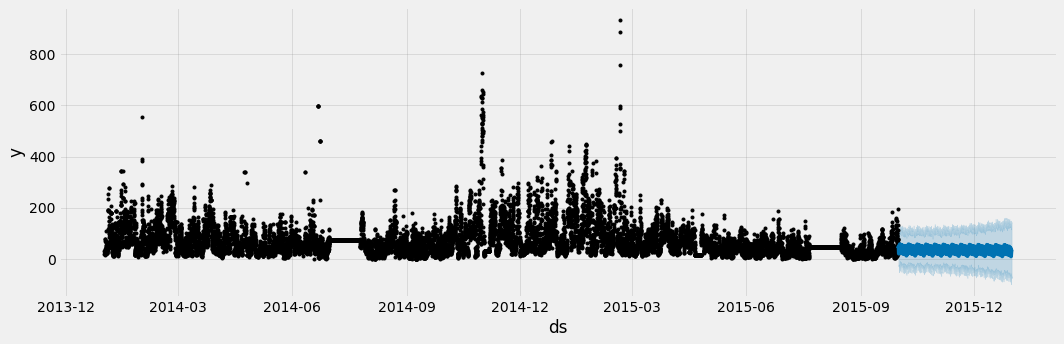

In [24]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(df_test_fcst,
                 ax=ax)
plt.show()

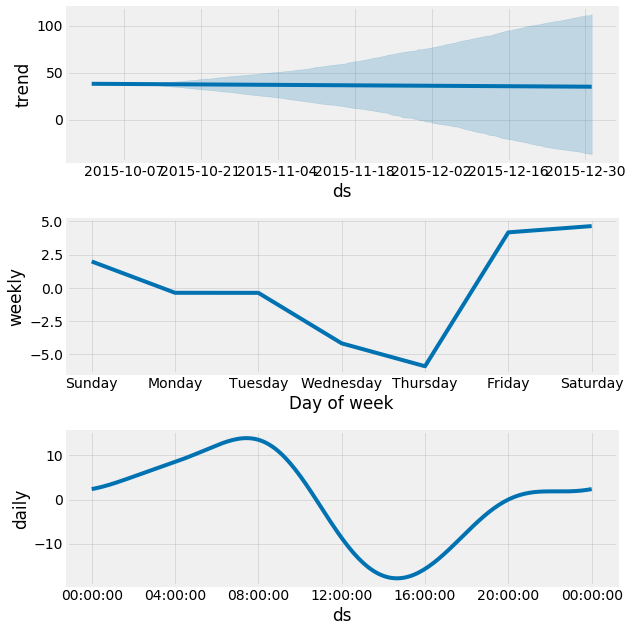

In [25]:
# Plot the components of the model
fig = model.plot_components(df_test_fcst)

In [26]:
###############################################################################################################

In [27]:
#Compare Forecast to Actuals

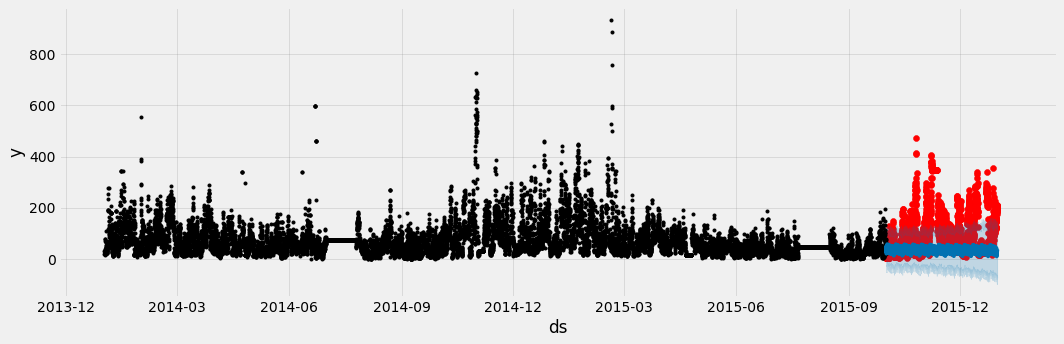

In [28]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_13_test.index, data_13_test['PM_US Post'], color='r')
fig = model.plot(df_test_fcst, ax=ax)

In [29]:
#Look at first month of predictions

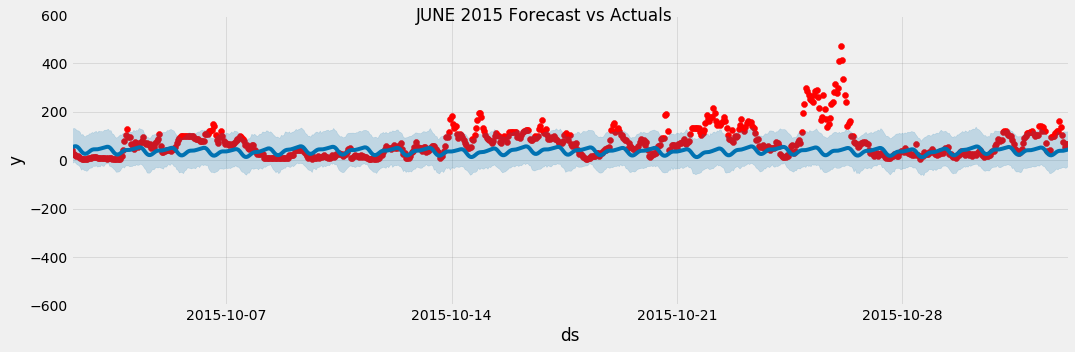

In [30]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_13_test.index, data_13_test['PM_US Post'], color='r')
fig = model.plot(df_test_fcst , ax=ax)

ax.set_xbound(lower=pd.to_datetime('20151002040000'),
              upper=pd.to_datetime('20151102040000'))
ax.set_ylim(-600, 600)
plot = plt.suptitle('JUNE 2015 Forecast vs Actuals')

In [31]:
###############################################################################################################

In [32]:
#Single Week of Predictions

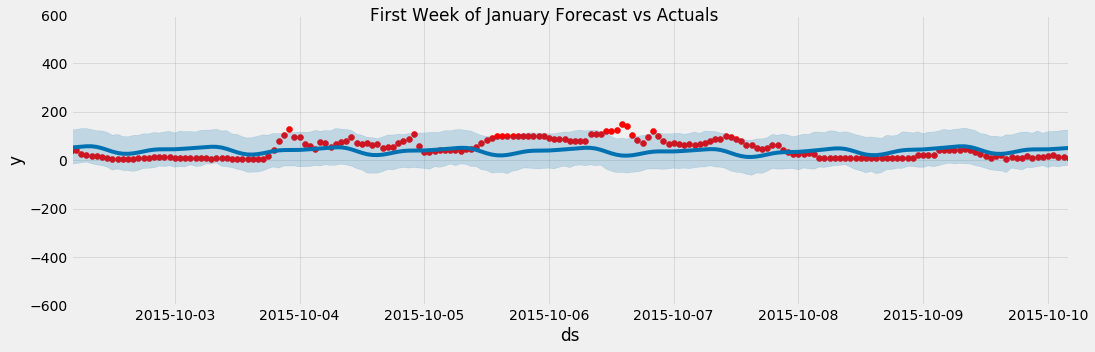

In [33]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_13_test.index, data_13_test['PM_US Post'], color='r')
fig = model.plot(df_test_fcst , ax=ax)

ax.set_xbound(lower=pd.to_datetime('20151002040000'),
              upper=pd.to_datetime('20151010040000'))
ax.set_ylim(-600, 600)
plot = plt.suptitle('First Week of January Forecast vs Actuals')